# EE4211 Project

       Team 1: Quadratic                   Done by Choi Jae Hyung, Lee Min Young, Nicholas Lui Ming Yang, Tran Duy Anh

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from functools import reduce



In [2]:
df = pd.read_csv("project_data.csv")
# df.shape - (1584823, 3)
# df column values:
# localminute - Timestamp 
# dataid - MeterID 
# meter_value - meter reading

# Q1.1

# How many houses are included in the measurement study?

In [3]:
# Since dataid is unique for each meter, we can count the number of unique dataid numbers
df.dataid.value_counts().size

157

### This gives us 157 for the number of houses included in the study

# Are there any malfunctioning meters? If so, identify them and the time periods where they were malfunctioning.

## There are various ways to define a malfunctioning meter. Let us explore some of them

### Let us first check, if there are *meters that report a lower value at a later timestamp*. Since meter_value is cumulative consumption, meter_value should not be lower at a later timestamp for the same meter

In [4]:
grouped = df.groupby(['dataid'], sort=['localminute'])
def has_decreasing_values(df):
    current_value = 0
    for index, val in df.iteritems():
        if val < current_value:
            return True
        current_value = val
        
meters_with_decreasing = (grouped['meter_value']
                          .agg(has_decreasing_values)
                          .where(lambda x: x)
                          .dropna()
                          .keys())

In [5]:
print(len(meters_with_decreasing))
meters_with_decreasing

43


Int64Index([  35,   77,   94,  483,  484, 1042, 1086, 1185, 1507, 1556, 1718,
            1790, 1801, 2129, 2335, 2449, 3134, 3527, 3544, 3893, 4031, 4193,
            4514, 4998, 5129, 5131, 5193, 5403, 5810, 5814, 5892, 6836, 7017,
            7030, 7117, 7739, 7794, 7989, 8156, 8890, 9134, 9639, 9982],
           dtype='int64', name='dataid')

#### Wow, we have 43 meters that have a decreasing value! Let's zoom in and get the offending sections for each meter. (In other words, find the exact data points which show this descreasing value)

In [6]:
## Need to re-sort after filter since filter takes all rows and breaks original sorting
dec_meters = (grouped.filter(lambda x: int(x.name) in meters_with_decreasing)
              .groupby(['dataid'], sort=['localminute']))

## Iterate over values to find offending rows for each meter
## WARNING: RUNS VERY SLOWLY. TODO: OPTIMIZE
offending_values = {}
for group_id, rows in dec_meters.groups.items():
    offending_values[group_id] = []
    current_value = 0
    group_rows = dec_meters.get_group(group_id)
    group_rows_count = group_rows.shape[0]
    for i in range(group_rows_count):
        if group_rows.iloc[i]['meter_value'] < current_value:
            offending_values[group_id].append([group_rows.iloc[i-1], group_rows.iloc[i]])
        current_value = group_rows.iloc[i]['meter_value']
    

##### Number of 'broken data' instances for each meter

In [7]:
print("Meter ID |", "Number of broken readings")
for k, v in offending_values.items():
    print(str(k).ljust(20), len(v))
        

Meter ID | Number of broken readings
35                   1
77                   1
94                   6
483                  1
484                  9
1042                 1
1086                 1
1185                 135
1507                 2
1556                 12
1718                 4
1790                 1
1801                 1
2129                 3
2335                 5
2449                 93
3134                 18
3527                 1
3544                 18
3893                 2
4031                 16
4193                 1
4514                 141
4998                 1
5129                 76
5131                 1
5193                 4
5403                 156
5810                 10
5814                 1
5892                 1
6836                 51
7017                 1
7030                 90
7117                 123
7739                 1
7794                 1
7989                 2
8156                 151
8890                 44
9134                 11

##### Just knowing the number of broken readings may not be useful. 
##### Let's say that we want to know which meters should be fixed, since faulty meters result in us inaccurately measuring consumption, and possibly losing money.
##### There should be some measure of tolerance in deciding if a meter is broken. In this case, let's check the average decreasing amount, and the ratio of "broken" readings 

In [8]:
print("Meter ID |", "Number of broken readings |", "Average decrease across broken readings |", "Percentage of broken readings for meter")
for k, v in offending_values.items():
    print(str(k).ljust(20), 
          str(len(v)).ljust(20), 
          str(reduce(lambda x, y: x + abs(y[1]['meter_value'] - y[0]['meter_value']) / len(v), [0] + v )).ljust(40), 
          (len(v) / dec_meters.get_group(k).shape[0]) * 100)

Meter ID | Number of broken readings | Average decrease across broken readings | Percentage of broken readings for meter
35                   1                    2.0                                      0.008423180592991915
77                   1                    2.0                                      0.009360666479453337
94                   6                    9.0                                      0.016513003990642632
483                  1                    14.0                                     0.0036195164326046038
484                  9                    2.4444444444444446                       0.020438751873552256
1042                 1                    2.0                                      0.02610966057441253
1086                 1                    2.0                                      0.003330114222917846
1185                 135                  16267.674074074097                       0.7314694408322496
1507                 2                    2.0    

#### With the data laid out like this, it is pretty clear that most meters are not really broken if we allow a 2% error rate
#### However, in terms of error volume, some are pretty suspect. Let's use an average volume error of 100 Cubic foot (that's a lot!) as our threshold, and filter our results

In [9]:
print("Meter ID |", "Number of broken readings |", "Average decrease across broken readings |", "Percentage of broken readings for meter")
for k, v in offending_values.items():
    measure = str(reduce(lambda x, y: x + abs(y[1]['meter_value'] - y[0]['meter_value']) / len(v), [0] + v )).ljust(40)
    if float(measure) > 10:
        print(str(k).ljust(20), 
              str(len(v)).ljust(20), 
              measure, 
              (len(v) / dec_meters.get_group(k).shape[0]) * 100)

Meter ID | Number of broken readings | Average decrease across broken readings | Percentage of broken readings for meter
483                  1                    14.0                                     0.0036195164326046038
1185                 135                  16267.674074074097                       0.7314694408322496
1556                 12                   13574.0                                  0.3252032520325203
2335                 5                    22942.0                                  0.05611672278338946
2449                 93                   15472.860215053784                       1.7067351807671134
3134                 18                   12877.222222222224                       0.4480955937266617
3544                 18                   8488.222222222223                        0.8104457451598379
4514                 141                  23971.8156028369                         0.7392261717521234
4998                 1                    14.0             

In [10]:
"""Use this function to validate/check each bad meter given our heuristic"""
def print_bad_meter_readings(meterID):
    meter_readings = offending_values[meterID]
    print("time apart |".ljust(20), "meter value initial |", "meter value after |", "difference")
    for readings_pair in meter_readings:

        print(str(pd.to_datetime(readings_pair[1]['localminute']) - pd.to_datetime(readings_pair[0]['localminute'])).ljust(25), 
              str(readings_pair[0]['meter_value']).ljust(20), 
              str(readings_pair[1]['meter_value']).ljust(20), 
              readings_pair[1]['meter_value'] - readings_pair[0]['meter_value'])
print_bad_meter_readings(1556)
        

time apart |         meter value initial | meter value after | difference
0 days 00:00:13           203154               203152               -2
0 days 00:06:59           203580               203578               -2
0 days 01:52:10.446150    223266               206892               -16374
0 days 00:15:09.023424    223266               206892               -16374
0 days 00:01:10.125932    223268               206910               -16358
0 days 02:14:09.533295    223282               206986               -16296
0 days 00:21:08.597335    223304               207046               -16258
0 days 01:39:08.641617    223306               207048               -16258
0 days 01:41:09.602248    223318               207066               -16252
0 days 00:46:07.782113    223320               207080               -16240
0 days 01:13:08.190968    223332               207094               -16238
0 days 00:14:06.456241    223340               207104               -16236


### Another requirement of the meters is that they push their readings to be saved if the meter values differ by at least 2 cubic foot
#### Let us verify that every pair of readings for a meter differ by at least 2 cubic foot. To not double count, we will only check for readings where the differing value is 0 >= x > 2 so that we don't get the same error readings where the readings decrease
#### Since the value is smaller, we will not focus on the difference in values, but on the percentage of total readings for the meter only

In [11]:
grouped2 = df.groupby(['dataid'], sort=['localminute'])
def has_stagnant_values(df):
    current_value = 0
    for index, val in df.iteritems():
        if index == 0:
            current_value = val
            continue
        
        if val < current_value + 2 and val >= current_value:
            return True
        current_value = val
        
meters_with_stagnant = (grouped['meter_value']
                          .agg(has_stagnant_values)
                          .where(lambda x: x)
                          .dropna()
                          .keys())

print("Number of meters with stagnant values: ", len(meters_with_stagnant))

Number of meters with stagnant values:  155


#### The following segment should have calculated the percentage of stagnant values for each meter, but it takes too long (tried for 5 minutes and gave up). At least we know number of meters that reported stagnant values?

In [12]:
# ## Need to re-sort after filter since filter takes all rows and breaks original sorting
# stagnant_meters = (grouped2.filter(lambda x: int(x.name) in meters_with_stagnant)
#               .groupby(['dataid'], sort=['localminute']))

# ## Iterate over values to count offending occurences. Not counting value
# ## WARNING: RUNS VERY SLOWLY. TODO: OPTIMIZE
# offending_values2 = {}
# for group_id, rows in stagnant_meters.groups.items():
#     offending_values2[group_id] = 0
#     group_rows = stagnant_meters.get_group(group_id)
#     group_rows_count = group_rows.shape[0]
#     # Set current_value so we do not trigger first reading
#     current_value = group_rows.iloc[0]['meter_value'] - 5
#     for i in range(group_rows_count):
#         if group_rows.iloc[i]['meter_value'] < current_value + 2 and group_rows.iloc[i]['meter_value'] >= current_value:
#             offending_values2[group_id] += 1
#         current_value = group_rows.iloc[i]['meter_value']

        
# print("Meter ID |", "Number of broken readings |", "Percentage of broken readings for meter")
# for k, v in offending_values2.items():
#     print(str(k).ljust(20), 
#           str(v).ljust(20),  
#           (v / stagnant_meters.get_group(k).shape[0]) * 100)


In [13]:
stagnant_meters = (grouped2.filter(lambda x: int(x.name) in meters_with_stagnant)
              .groupby(['dataid'], sort=['localminute']))

print("Total number of readings to iterate, which is why it is slow: ", 
      reduce(lambda x, y: x + len(y), [0] + list(stagnant_meters.groups.values())))

Total number of readings to iterate, which is why it is slow:  1584818


### We now have two different criterion for deciding what constitues a broken meter, and the readings that helped us determine that. Since the question asks for "time periods where they were malfunctioning.", let's demonstrate that we can consolidate broken readings into time periods

In [31]:
# let's use the meter with the most broken readings (based off decreasing values)
most_broken_values_meter = grouped.get_group(5403)

In [39]:
# We are using a stricter requirement now. Let's consider that, if the subsequent meter reading is less 
# than an increment of 2 (meters are only supposed to report after at least an increment of 2)

# Broken_criteria is a helper function (comparator function) that takes in two (in-order) readings and outputs a 
# boolean of whether the later reading is "broken"

broken_criteria = lambda x, y: y['meter_value'] < x['meter_value'] + 2

In [40]:
broken_readings = 0
num_readings = most_broken_values_meter.shape[0]
for i in range(1, num_readings):
    if broken_criteria(most_broken_values_meter.iloc[i-1], most_broken_values_meter.iloc[i]):
        broken_readings += 1

print("Number of broken readings for meter 5403, based on stricter requirements: ", broken_readings)

Number of broken readings for meter 5403, based on stricter requirements:  21371


In [43]:
# Let's now create a function that can aggregate a meter's readings into "broken" time periods
# Return value of the function will be as follow:
"""
2D array. 
First dimension is the time periods. 
Second dimension is the consecutive broken readings that make up the broken time period
To find the actual time data, take the ['localminute'] attribute from the first and last reading per period
    time_periods = [
        [reading_1, reading_2, reading_3],
        [reading_1, reading_2]
    ]
"""
def get_broken_time_periods(broken_criteria, meter_readings):
    num_readings = meter_readings.shape[0]
    time_periods = []
    temp_period = []
    for i in range(1, num_readings):
        if broken_criteria(meter_readings.iloc[i-1], meter_readings.iloc[i]):
            temp_period.append(meter_readings.iloc[i])
        else:
            if temp_period:
                time_periods.append(temp_period)
                temp_period = []
    if temp_period:
        time_periods.append(temp_period)
    return time_periods

In [48]:
broken_time_periods = get_broken_time_periods(broken_criteria, most_broken_values_meter)
print("Number of broken time periods: ", len(broken_time_periods))


Number of broken time periods:  3545


# Q1.2

#### Data ID of 739 will be focused for the study.

In [14]:
df_739 = df.loc[df['dataid'] == 739]
df_739_date = pd.to_datetime(df_739['localminute'])

In [15]:
df_739.index = range(31430)
df_739_date.index = range(31430)
df_739_date.dt.hour.index = range(31430)

#### The data is collected to form hourly data from 1st Oct 2015 6 a.m. to 1st Nov 2015 6 a.m.
##### When it comes to missing data for an hour, it is assumed that there is no gas consumption. It is to prevent over-estimation implied from assumption that the consumer has been using the gas consistently in between the missing hours.

In [16]:
Oct_dates = ['2015-10-01', '2015-10-02', '2015-10-03','2015-10-04','2015-10-05','2015-10-06','2015-10-07','2015-10-08','2015-10-09','2015-10-10','2015-10-11', '2015-10-12', '2015-10-13','2015-10-14','2015-10-15','2015-10-16','2015-10-17','2015-10-18','2015-10-19','2015-10-20', '2015-10-21', '2015-10-22', '2015-10-23','2015-10-24','2015-10-25','2015-10-26','2015-10-27','2015-10-28','2015-10-29','2015-10-30', '2015-10-31', '2015-11-01']

hour = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']

Oct_hourly_meter = []

v1 = 0  #Variable 1: row no. of dataframe, for "for loop"
v2 = 5  #Variable 2: indicates the 1st hour is "6 a.m." (Most recent hour beyond 5 a.m.) and the meter data has to be noted.
v3 = 0  #Variable 3: row no. of hourly meter value in October 2015
v4 = 1  #Variable 4: Day (e.g. Day-Month-Year)
test1 = 0
missing_data = 0  #Missing_data: This indicates whether there is hourly missing data in the previous hour.


for v1 in range (0, 99999):
    
    if (df_739_date.dt.hour[v1] == v2):
        
        if (test1 == 0):
            print ("Hour:", v2)
            test1 = 1
            
    else:
       
        #First meter value is 1st Oct 2015, 6 a.m.
        print (v1)
        Oct_hourly_meter.append(df_739.meter_value[v1-1])  #One data prior to the time going beyond a new hour hand is assumed to be the meter value when the new hour strikes.
        
        print ("value is stored into v3. v3 =", v3)

        test1 = 0
        v2 = v2 + 1
        v3 = v3 + 1
            
        if (v2 == 24):
            print ("Hour changed from 24 to 0")
            print (Oct_dates[v4])
            v2 = 0
            v4 = v4 + 1
                
        if (df_739_date.dt.hour[v1] != v2):
            print ("There is missing data for an hour...................................................................")
            v2 = v2 + 1
            Oct_hourly_meter.append(df_739.meter_value[v1-1])
    
        if (df_739_date.dt.month[v1] == 11):
            if (v2 == 6):
                print ("Hourly data of October 2015 has been collected.")
                break
             
      
    if (v1 == 31430):
        break


Hour: 5
11
value is stored into v3. v3 = 0
Hour: 6
18
value is stored into v3. v3 = 1
Hour: 7
22
value is stored into v3. v3 = 2
Hour: 8
25
value is stored into v3. v3 = 3
Hour: 9
33
value is stored into v3. v3 = 4
Hour: 10
39
value is stored into v3. v3 = 5
Hour: 11
44
value is stored into v3. v3 = 6
Hour: 12
56
value is stored into v3. v3 = 7
Hour: 13
60
value is stored into v3. v3 = 8
Hour: 14
64
value is stored into v3. v3 = 9
Hour: 15
74
value is stored into v3. v3 = 10
Hour: 16
80
value is stored into v3. v3 = 11
Hour: 17
89
value is stored into v3. v3 = 12
Hour: 18
101
value is stored into v3. v3 = 13
Hour: 19
108
value is stored into v3. v3 = 14
Hour: 20
115
value is stored into v3. v3 = 15
Hour: 21
120
value is stored into v3. v3 = 16
Hour: 22
131
value is stored into v3. v3 = 17
Hour: 23
139
value is stored into v3. v3 = 18
Hour changed from 24 to 0
2015-10-02
Hour: 0
147
value is stored into v3. v3 = 19
Hour: 1
156
value is stored into v3. v3 = 20
Hour: 2
167
value is stored

Hour: 11
1394
value is stored into v3. v3 = 174
Hour: 12
1401
value is stored into v3. v3 = 175
Hour: 13
1408
value is stored into v3. v3 = 176
Hour: 14
1414
value is stored into v3. v3 = 177
Hour: 15
1423
value is stored into v3. v3 = 178
Hour: 16
1431
value is stored into v3. v3 = 179
Hour: 17
1439
value is stored into v3. v3 = 180
Hour: 18
1446
value is stored into v3. v3 = 181
Hour: 19
1450
value is stored into v3. v3 = 182
Hour: 20
1463
value is stored into v3. v3 = 183
Hour: 21
1467
value is stored into v3. v3 = 184
Hour: 22
1475
value is stored into v3. v3 = 185
Hour: 23
1483
value is stored into v3. v3 = 186
Hour changed from 24 to 0
2015-10-09
Hour: 0
1490
value is stored into v3. v3 = 187
Hour: 1
1501
value is stored into v3. v3 = 188
Hour: 2
1512
value is stored into v3. v3 = 189
Hour: 3
1521
value is stored into v3. v3 = 190
Hour: 4
1528
value is stored into v3. v3 = 191
Hour: 5
1535
value is stored into v3. v3 = 192
Hour: 6
1542
value is stored into v3. v3 = 193
Hour: 7
15

2685
value is stored into v3. v3 = 345
Hour: 15
2699
value is stored into v3. v3 = 346
Hour: 16
2705
value is stored into v3. v3 = 347
Hour: 17
2711
value is stored into v3. v3 = 348
Hour: 18
2719
value is stored into v3. v3 = 349
Hour: 19
2729
value is stored into v3. v3 = 350
Hour: 20
2739
value is stored into v3. v3 = 351
Hour: 21
2750
value is stored into v3. v3 = 352
Hour: 22
2762
value is stored into v3. v3 = 353
Hour: 23
2768
value is stored into v3. v3 = 354
Hour changed from 24 to 0
2015-10-16
Hour: 0
2777
value is stored into v3. v3 = 355
Hour: 1
2783
value is stored into v3. v3 = 356
Hour: 2
2790
value is stored into v3. v3 = 357
Hour: 3
2800
value is stored into v3. v3 = 358
Hour: 4
2806
value is stored into v3. v3 = 359
Hour: 5
2811
value is stored into v3. v3 = 360
Hour: 6
2813
value is stored into v3. v3 = 361
Hour: 7
2819
value is stored into v3. v3 = 362
Hour: 8
2831
value is stored into v3. v3 = 363
Hour: 9
2839
value is stored into v3. v3 = 364
Hour: 10
2845
value is

Hour: 13
3990
value is stored into v3. v3 = 512
Hour: 14
3994
value is stored into v3. v3 = 513
Hour: 15
4001
value is stored into v3. v3 = 514
Hour: 16
4008
value is stored into v3. v3 = 515
Hour: 17
4016
value is stored into v3. v3 = 516
Hour: 18
4024
value is stored into v3. v3 = 517
Hour: 19
4029
value is stored into v3. v3 = 518
Hour: 20
4040
value is stored into v3. v3 = 519
Hour: 21
4047
value is stored into v3. v3 = 520
Hour: 22
4055
value is stored into v3. v3 = 521
Hour: 23
4061
value is stored into v3. v3 = 522
Hour changed from 24 to 0
2015-10-23
Hour: 0
4065
value is stored into v3. v3 = 523
Hour: 1
4071
value is stored into v3. v3 = 524
Hour: 2
4083
value is stored into v3. v3 = 525
Hour: 3
4091
value is stored into v3. v3 = 526
Hour: 4
4101
value is stored into v3. v3 = 527
Hour: 5
4110
value is stored into v3. v3 = 528
Hour: 6
4123
value is stored into v3. v3 = 529
Hour: 7
4132
value is stored into v3. v3 = 530
Hour: 8
4139
value is stored into v3. v3 = 531
Hour: 9
4144

value is stored into v3. v3 = 687
Hour: 21
5262
value is stored into v3. v3 = 688
Hour: 22
5270
value is stored into v3. v3 = 689
Hour: 23
5276
value is stored into v3. v3 = 690
Hour changed from 24 to 0
2015-10-30
Hour: 0
5281
value is stored into v3. v3 = 691
Hour: 1
5290
value is stored into v3. v3 = 692
Hour: 2
5301
value is stored into v3. v3 = 693
Hour: 3
5307
value is stored into v3. v3 = 694
Hour: 4
5321
value is stored into v3. v3 = 695
Hour: 5
5326
value is stored into v3. v3 = 696
Hour: 6
5341
value is stored into v3. v3 = 697
Hour: 7
5349
value is stored into v3. v3 = 698
Hour: 8
5356
value is stored into v3. v3 = 699
Hour: 9
5366
value is stored into v3. v3 = 700
Hour: 10
5376
value is stored into v3. v3 = 701
Hour: 11
5382
value is stored into v3. v3 = 702
Hour: 12
5388
value is stored into v3. v3 = 703
Hour: 13
5395
value is stored into v3. v3 = 704
Hour: 14
5406
value is stored into v3. v3 = 705
Hour: 15
5413
value is stored into v3. v3 = 706
Hour: 16
5422
value is stor

#### The vertical limit of the graph is gauged by the lowest cumulative value of the gas consumption to the highest

In [17]:
ylim_low = Oct_hourly_meter[0]
ylim_high = Oct_hourly_meter[744]
print (ylim_low, ylim_high)

88858 89558


#### Here is the plot of the hourly reading of October 2015

Text(0,0.5,'Meter value')

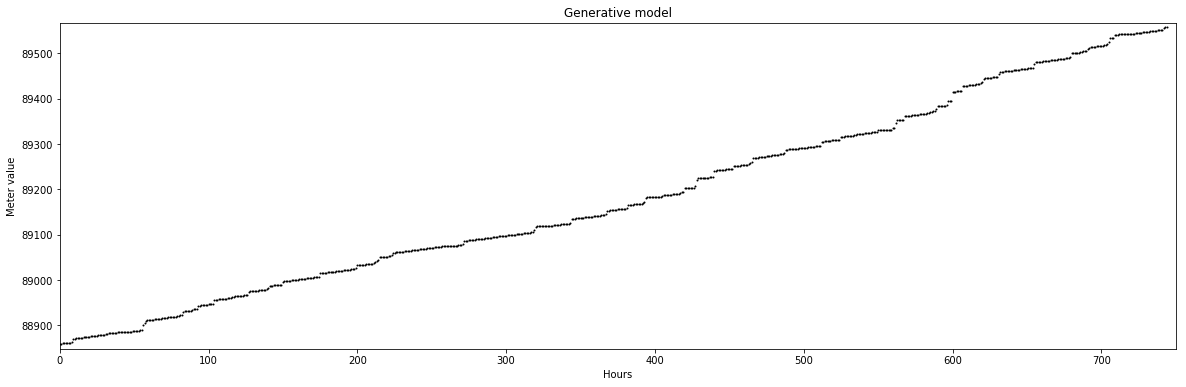

In [18]:
x = np.arange(745)     #[0,1,2,...,741,742,743]

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
ax.plot(x, Oct_hourly_meter, 'ok', ms=1)
ax.set_xlim(0, 750)
ax.set_ylim(ylim_low-10, ylim_high+10)
ax.set_title('Generative model')
plt.xlabel ("Hours")
plt.ylabel ("Meter value")